In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data, make_diamonds_partial_holdout, make_branch_cond
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [3]:
phate_dims = 5
df = make_branch_cond(ne=2, n_colors=5, repeats=20)
# df = df[~((df['e1'] == 1) & (df['samples'].isin([4])))]
df.drop(columns=['e1'], inplace=True)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df[['d1', 'd2']] = scaler.fit_transform(df[['d1', 'd2']])

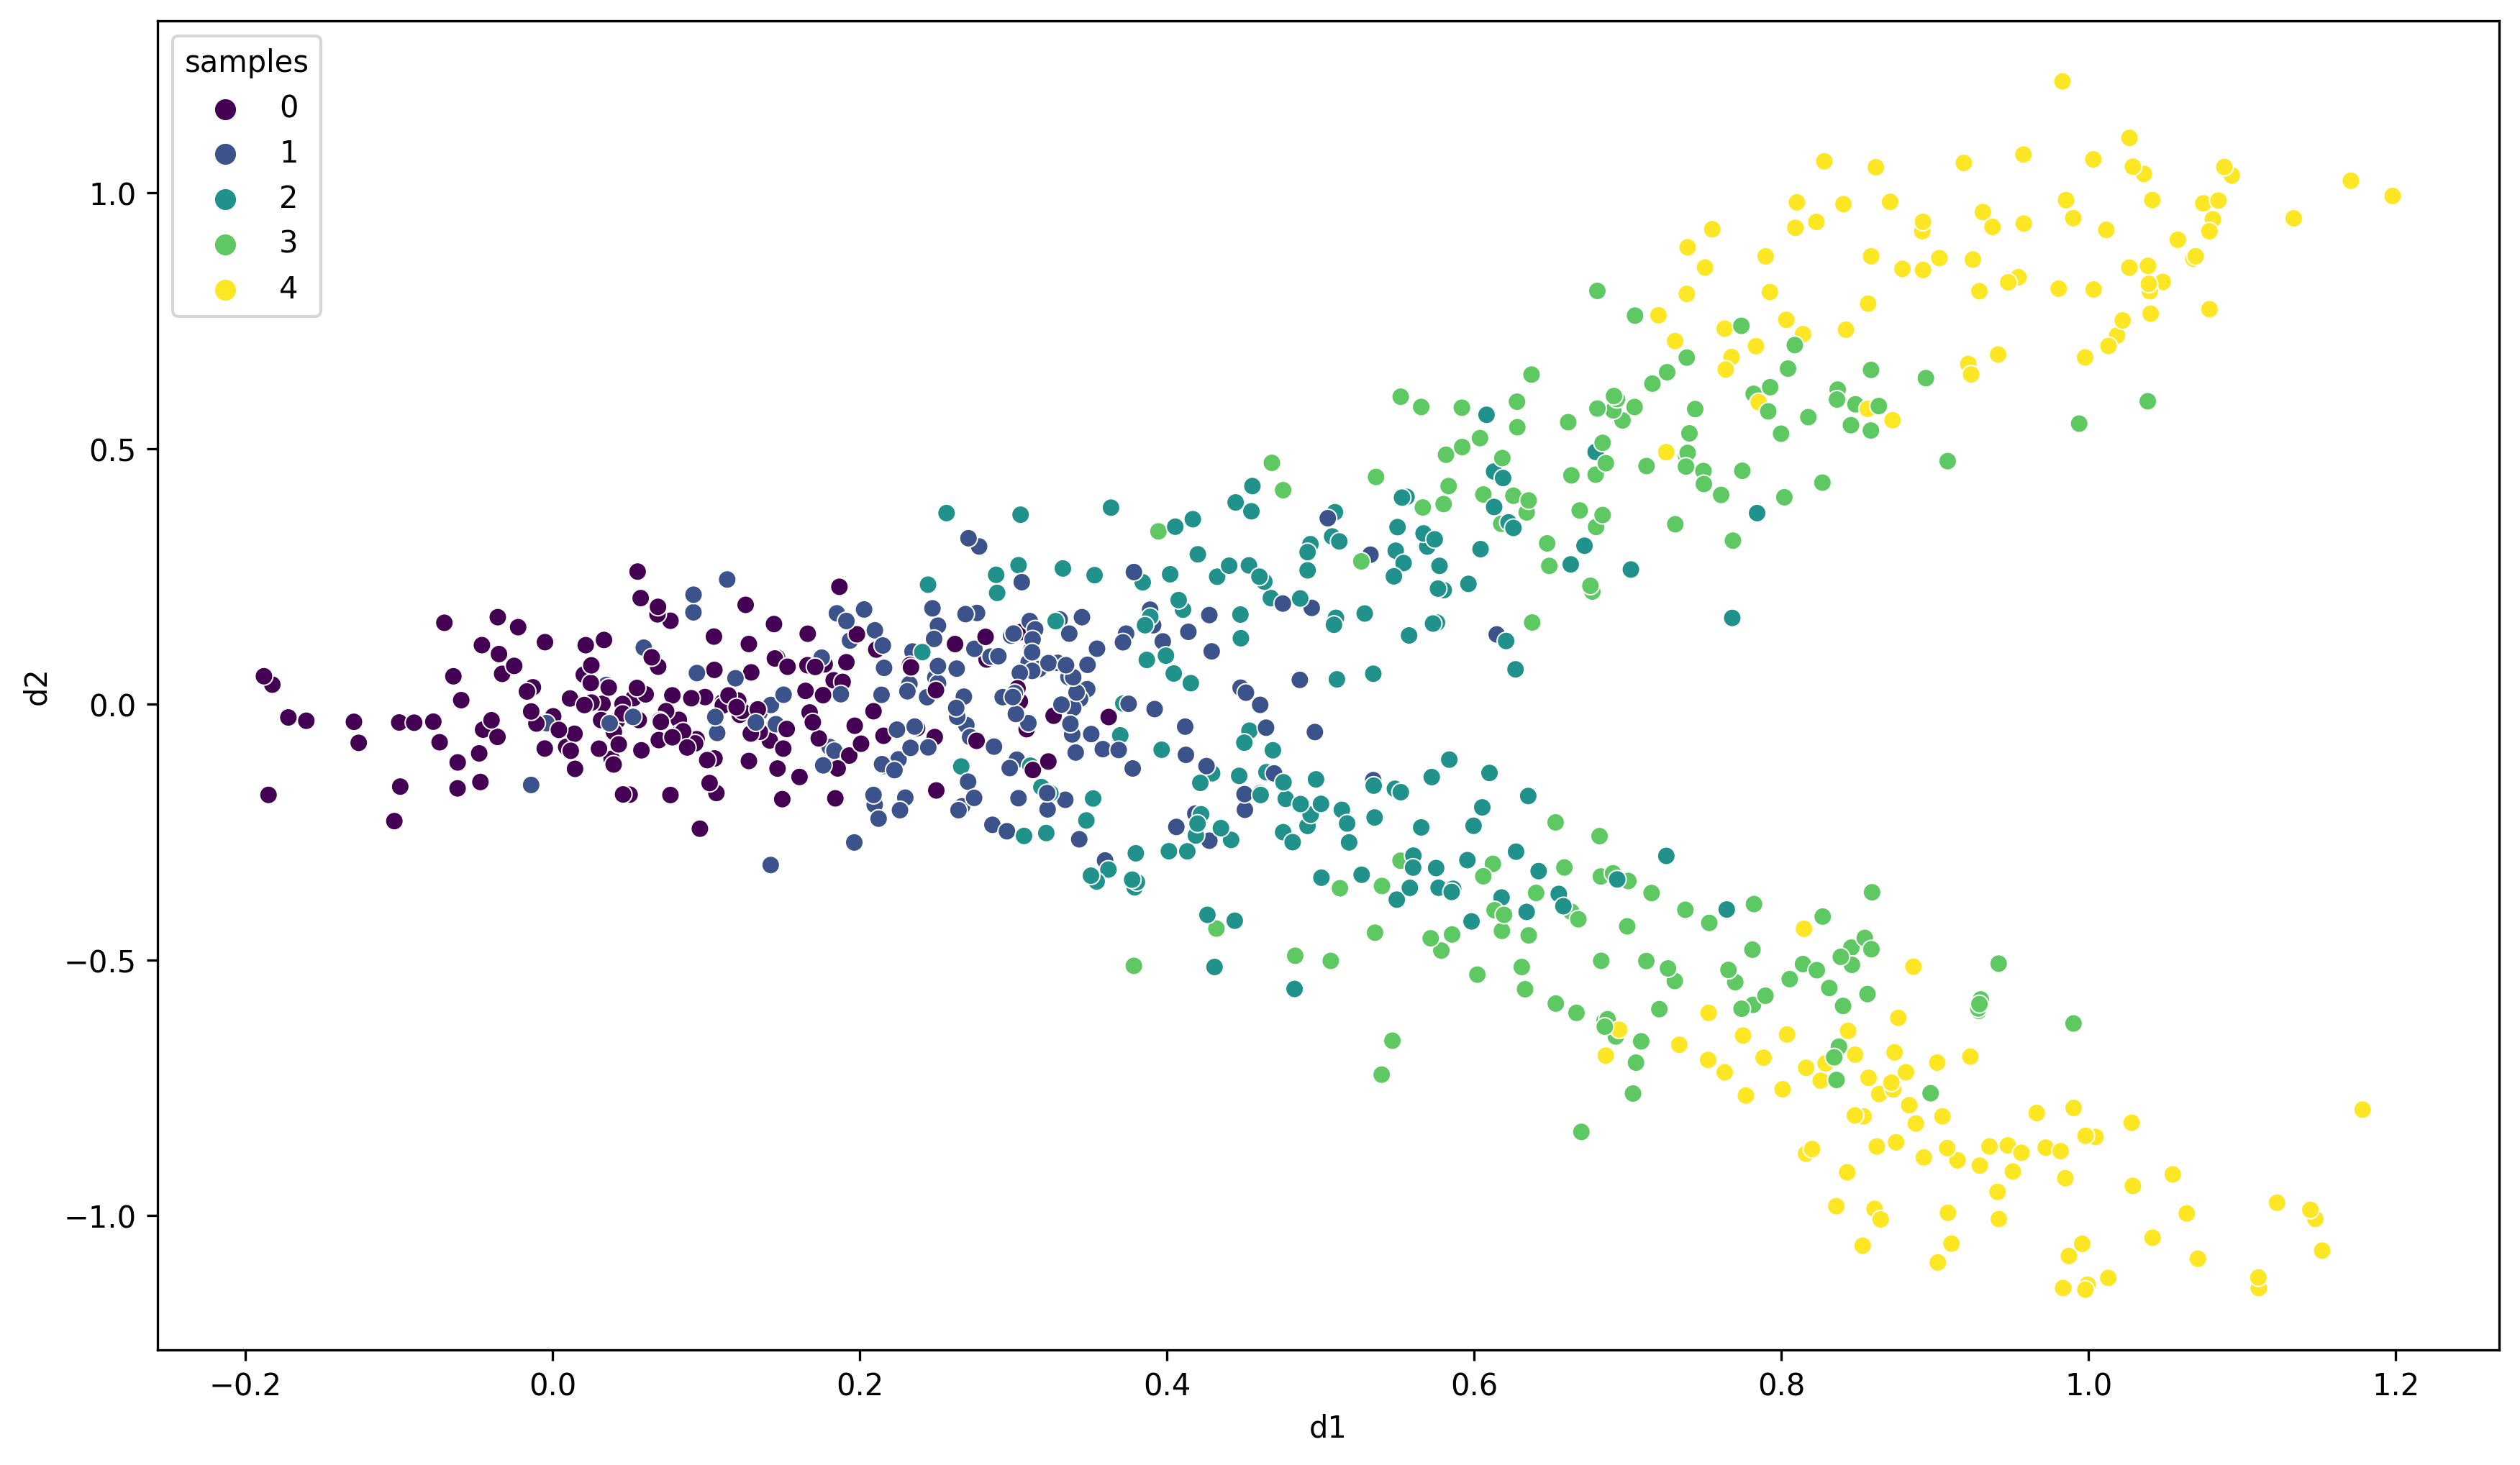

In [4]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [5]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [6]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [7]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 32
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [8]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [9]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 35

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda,
    which='ode_growth_rate',
)

In [10]:
# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


# criterion_name = 'ot'
criterion_name = 'density_specified_ot'
criterion = config_criterion(criterion_name, reg=0.2, detach_M_ot=True)
print(criterion.softmax)
print(criterion.detach_M_ot)


optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


<function density_specified_OT_loss.__init__.<locals>.<lambda> at 0x1043d3380>
True


In [11]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [12]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [13]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [14]:
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

In [26]:
with torch.no_grad():
    x_traj, m_traj = model(data_t0, sample_time, return_whole_sequence=True)
    m_traj = nn.functional.softmax(m_traj, dim=-1)
x_traj = x_traj.cpu().numpy()
m_traj = m_traj.cpu().numpy()
# m_traj = m_traj / m_traj.max()
# m_traj = np.exp(m_traj)
m_traj = m_traj / m_traj[0,0]

In [27]:
x_traj.shape

(100, 100, 2)

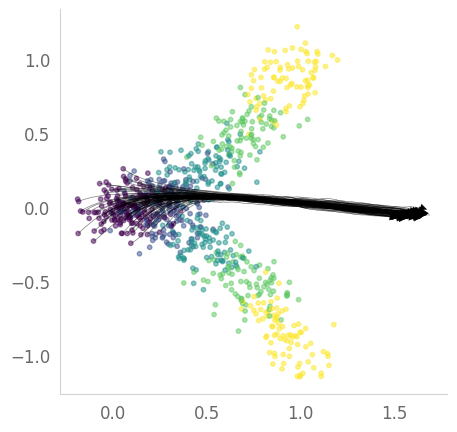

In [28]:
plt.figure(figsize=(5, 5))
plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

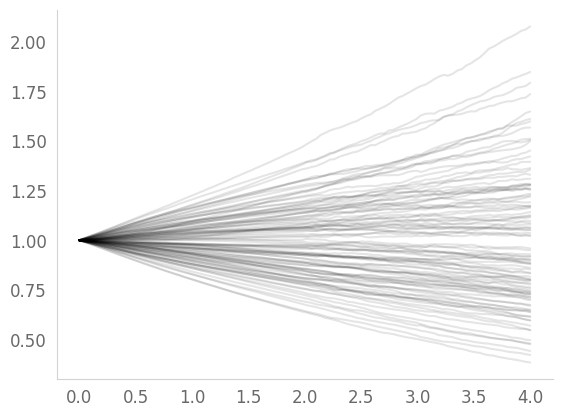

In [30]:
plt.figure()
for i in range(n_points):
    plt.plot(sample_time.cpu().numpy(), m_traj[:,i], c='black', alpha=0.1)

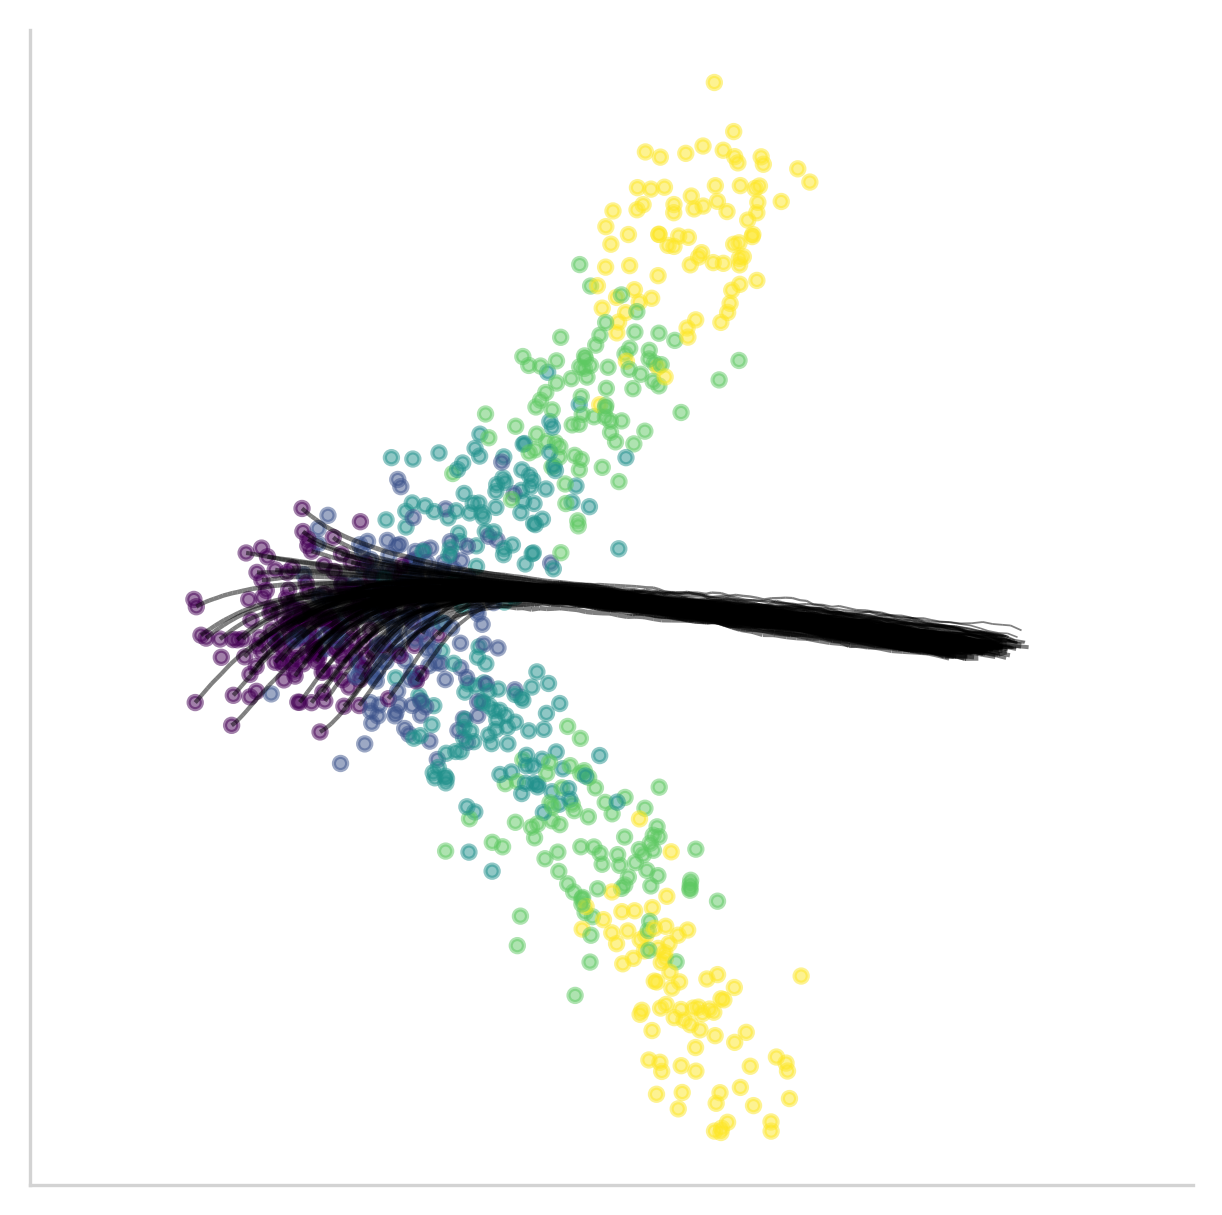

In [29]:
from matplotlib.collections import LineCollection

plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # Use the width array to determine the linewidths for this trajectory
    linewidths = m_traj[:,i]
    
    # Create segments for the trajectory
    segments = [np.array([traj[j], traj[j+1]]) for j in range(len(traj)-1)]
    
    # Create a LineCollection with the segments and the corresponding linewidths
    lc = LineCollection(segments, linewidths=linewidths, color='black', alpha=0.5)
    plt.gca().add_collection(lc)

    # Add the arrow at the end of the trajectory
    # plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
    #              arrowprops=dict(arrowstyle="-|>", color='Black', lw=.05))
# Autoscale to adjust plot limits
plt.gca().autoscale()
plt.xticks([])  # Hides x-axis ticks
plt.yticks([])  # Hides y-axis ticks
plt.axis('equal')

plt.show()

In [19]:
m_traj

array([[1.0000000e+00, 7.4364907e-01, 9.6785188e-01, ..., 8.5717958e-01,
        1.1438082e+00, 1.1137240e+00],
       [1.0608624e+00, 7.9435021e-01, 1.0302082e+00, ..., 9.1309834e-01,
        1.2156284e+00, 1.1812340e+00],
       [1.1259184e+00, 8.4980780e-01, 1.0984533e+00, ..., 9.7218657e-01,
        1.2916131e+00, 1.2541261e+00],
       ...,
       [9.7177871e+03, 9.8236230e+03, 9.6167656e+03, ..., 9.6509229e+03,
        9.6189082e+03, 9.5851025e+03],
       [1.1052273e+04, 1.1297910e+04, 1.1009022e+04, ..., 1.0991060e+04,
        1.0946830e+04, 1.0859749e+04],
       [1.2655360e+04, 1.2979791e+04, 1.2608155e+04, ..., 1.2580442e+04,
        1.2498263e+04, 1.2400958e+04]], dtype=float32)

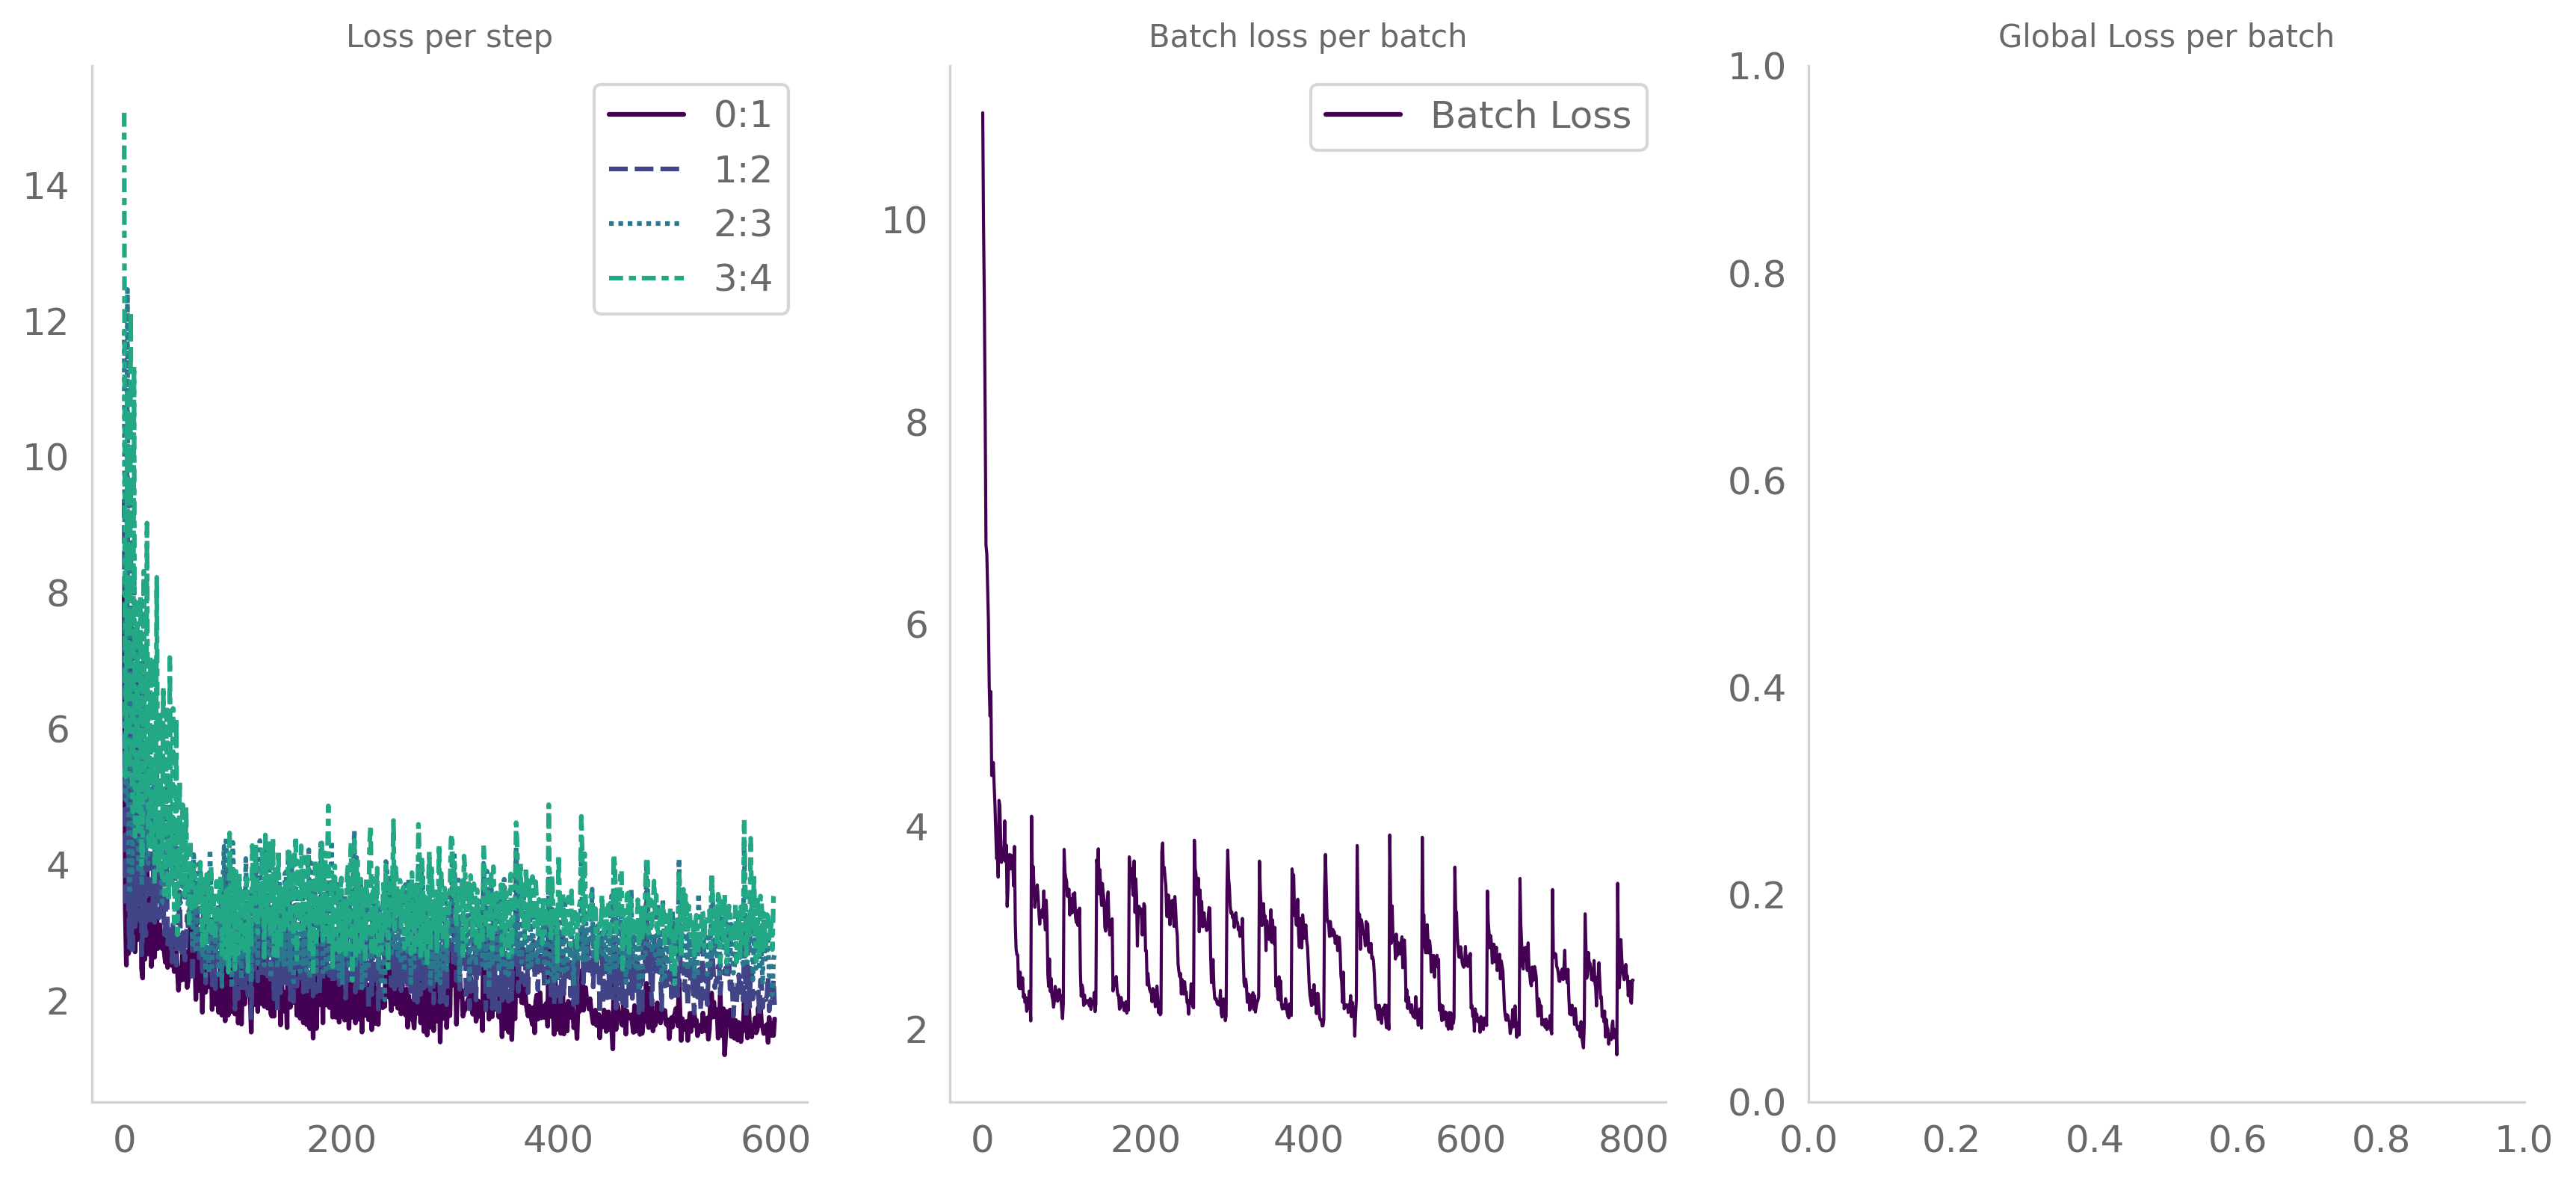

In [20]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [21]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

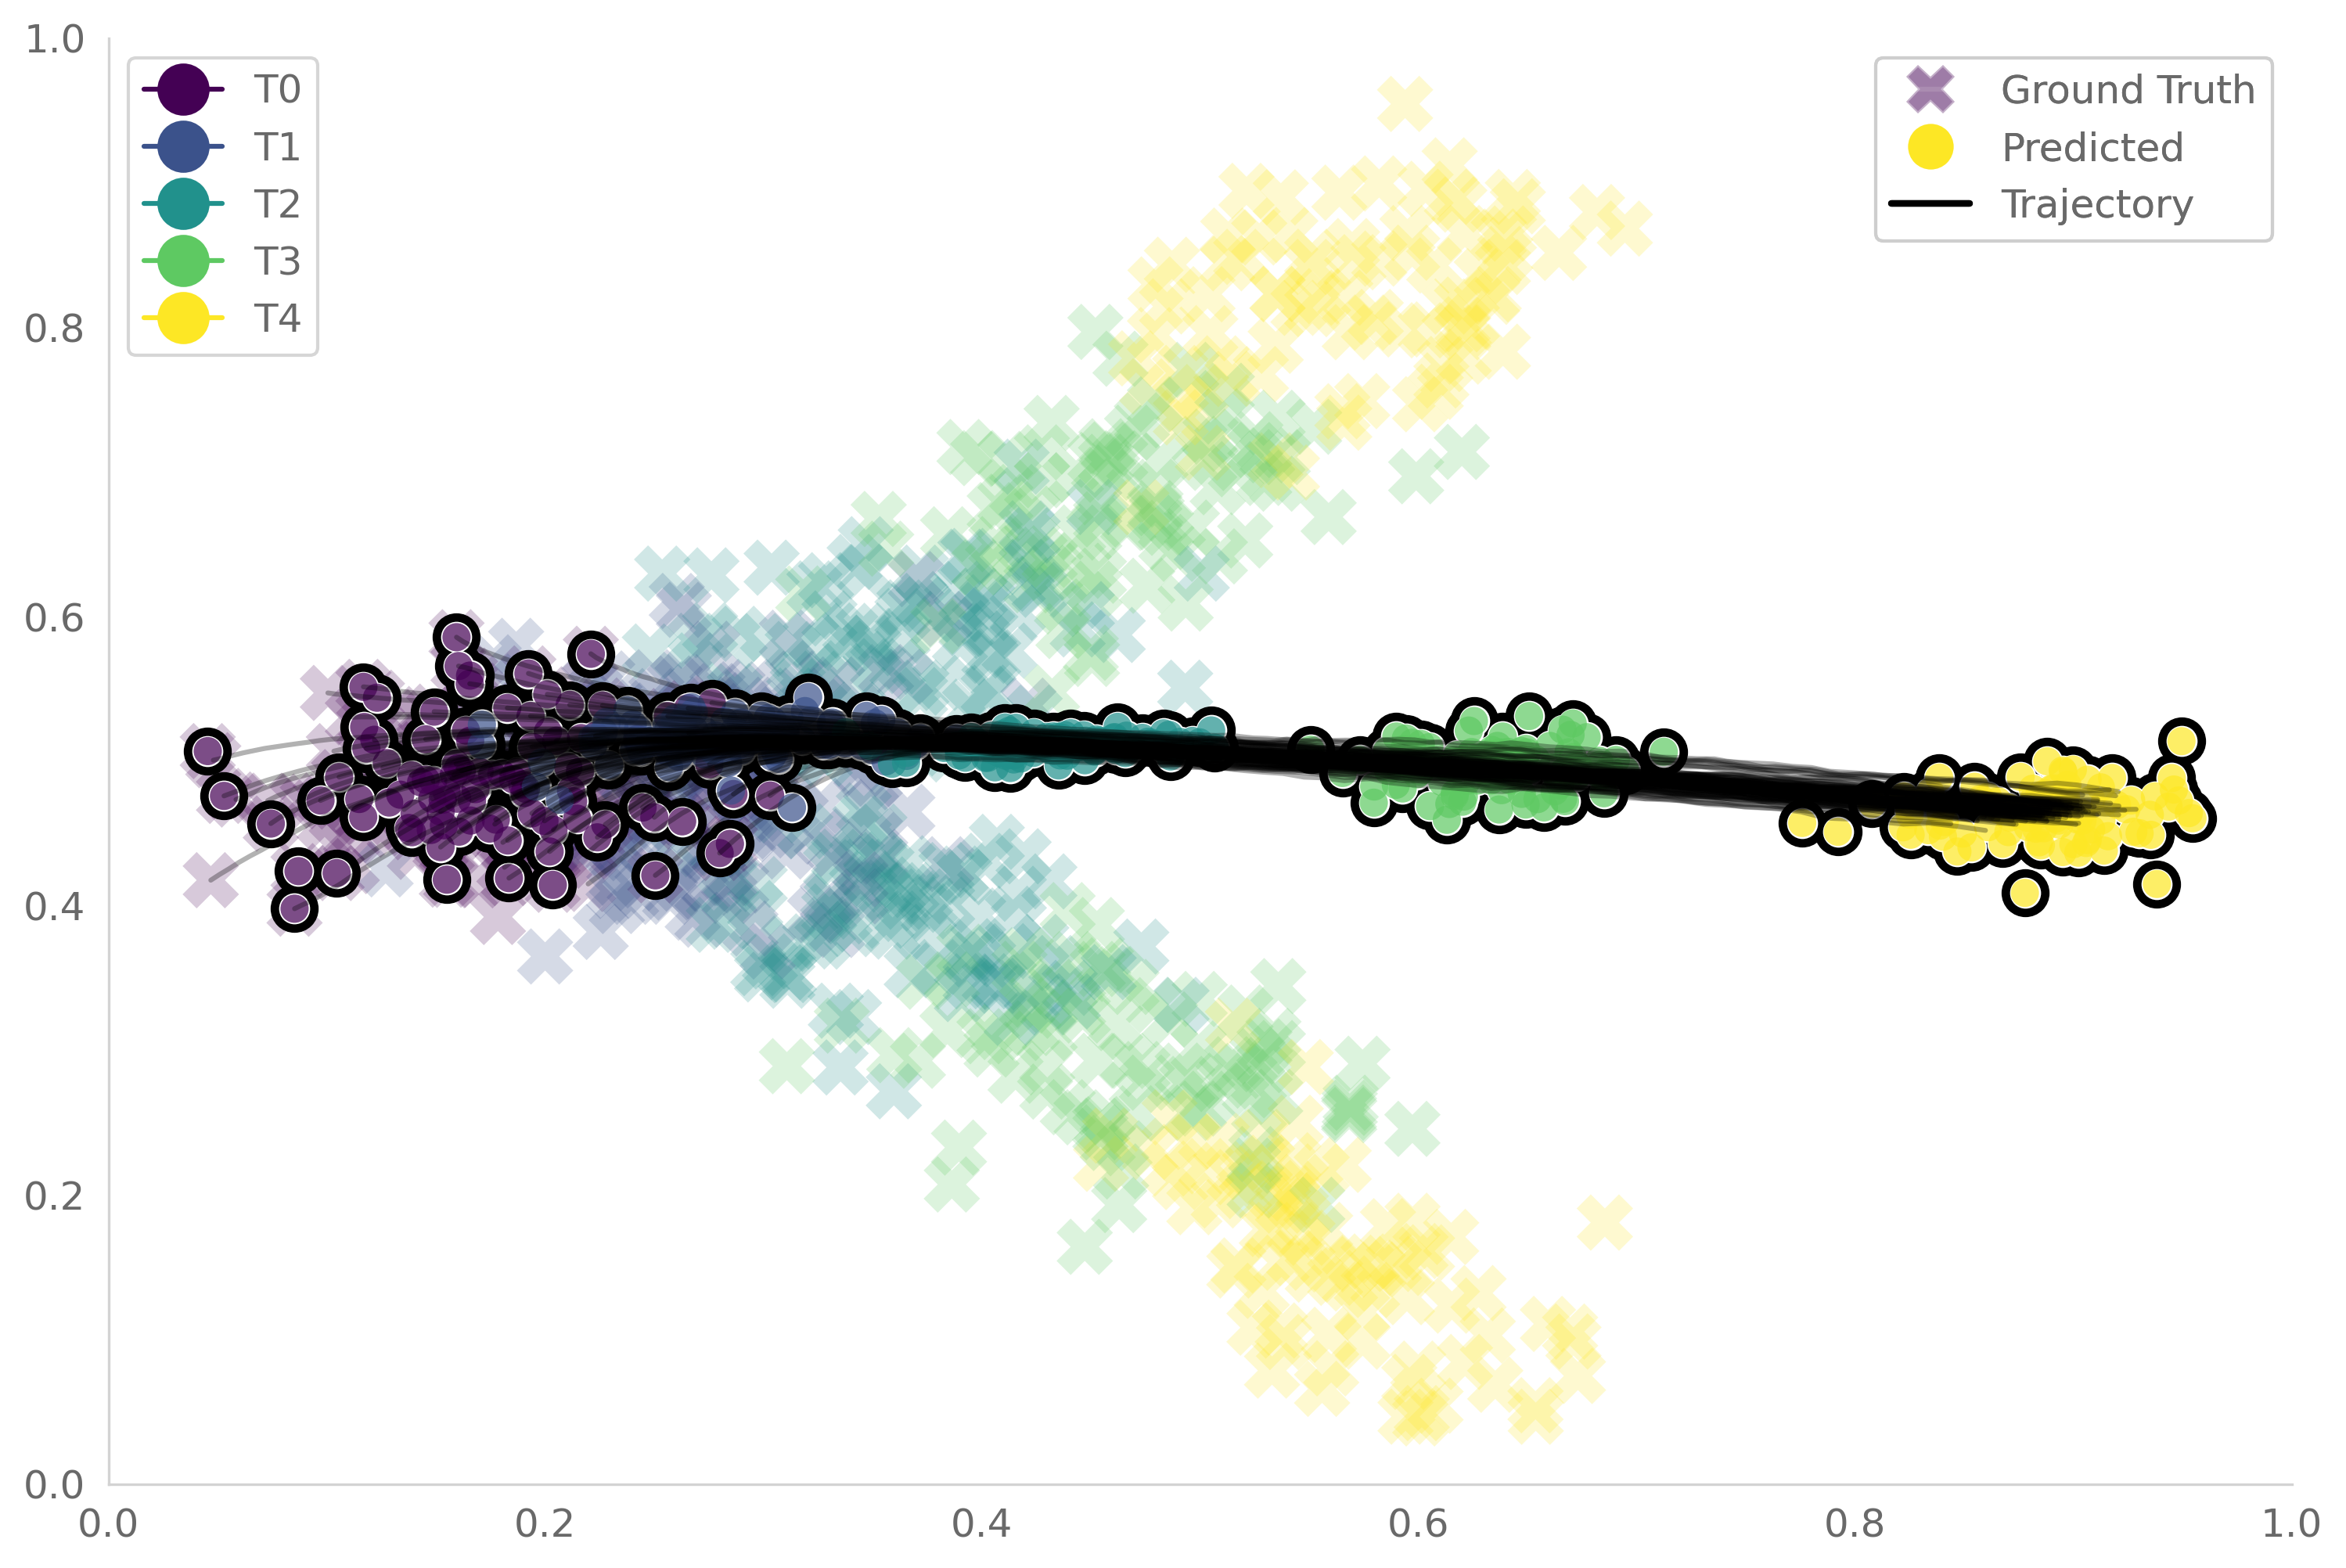

In [22]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

In [23]:
# saving the trajectories and generated points
# np.save(os.path.join(exp_dir,'trajectories_petal.npy'),trajectories)
# np.save(os.path.join(exp_dir,'generated_petal.npy'),generated)

In [24]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [25]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)